Connect to Google Drive account

In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd drive/My\ Drive/


Mounted at /content/drive
/content/drive/My Drive


# Face Recognition layer

Dataset: https://www.kaggle.com/havingfun/100-bollywood-celebrity-faces

Install Facenet model package to generate face embeddings

In [ ]:
!pip install keras-facenet


Load Images from directory and store them in a numpy file 

In [ ]:
import os
dataset=[]
labels=[]

images_directories=['bollywood_celeb_faces_0']
for i in images_directories:
  for j in  os.listdir(i):
    for k in os.listdir(i+'/'+j):
      if '.jpg' in k:
        dataset.append(i+'/'+j+'/'+k)
        labels.append(j)


In [ ]:
import numpy as np
from PIL import Image
loaded_images=[]
count=0
for i in dataset[:4000]:
  loaded_images.append(np.asarray(Image.open(i)))
  print(count)
  count+=1
print('done')
loaded_images=np.array(loaded_images)
# np.save('face_dataset_0_1',loaded_images)


In [ ]:
print('Classes: ',set(labels))

Load Facenet

In [ ]:
from keras_facenet import FaceNet

embedder = FaceNet()


Generate embeddings for stored images

In [ ]:
embeddings=[]
new_labels=[]
count=0
fail=0
for i in range(len(arr)):
  try:
    detections = embedder.extract(arr[i], threshold=0.95)
    embeddings.append(detections[0]['embedding'])
    new_labels.append(labels[i])
    print(count)
    count+=1
  except:
    fail+=1
print(fail)
print(count)

Label Encoding

In [ ]:
actor_to_number={}
number=0
for i in new_labels:
  if i not in actor_to_number.keys():
    actor_to_number[i]=number
    number+=1

labels_to_number=[]
for i in new_labels:
  labels_to_number.append(actor_to_number[i])

Using SVC with One v/s rest as the classifier 

In [ ]:
from sklearn.svm import SVC
from sklearn.preprocessing import Normalizer
from keras.utils import np_utils
from sklearn.model_selection import train_test_split
in_encoder = Normalizer(norm='l2')
Xtrain,Xtest,Ytrain,Ytest=train_test_split(np.array(embeddings),labels_to_number,test_size=0.3)
s=SVC(decision_function_shape='ovr').fit(Xtrain,Ytrain)


Test Accuracy

In [ ]:
s.score(Xtest,Ytest)

0.9884649511978705

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


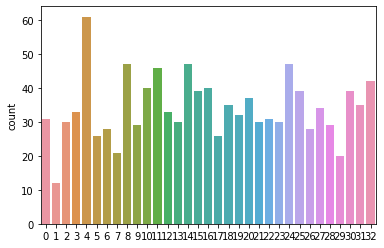

In [ ]:
sns.countplot(s.predict(Xtest))

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


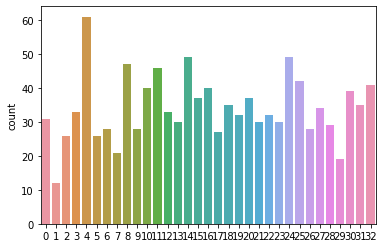

In [ ]:
sns.countplot(Ytest)

Save the model file

In [ ]:
import pickle
filename = 'facenet_svc.sav'
pickle.dump(s, open(filename, 'wb'))

Predictor

In [ ]:
model=pickle.load(open('facenet_svc.sav','rb'))
model.score(Xtest,Ytest)

0.9884649511978705

# Violence Detection layer

Extract the dataset. Dataset link:https://www.kaggle.com/mohamedmustafa/real-life-violence-situations-dataset

In [ ]:
from zipfile import ZipFile
filename='violence.zip'

with ZipFile(filename,'r') as zip:
  zip.extractall()

Import all the relevant libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2 
import math
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier


Extract frames from both the Violent and Non-Violent Videos

In [4]:
X = []
count = 0
for i in range (1,1000):
    videoFile = "real life violence situations/Real Life Violence Dataset/Violence/V_%d.mp4" % i
    cap = cv2.VideoCapture(videoFile)   # capturing the video from the given path
    frameRate = cap.get(5) #frame rate
    #print(cap.isOpened())
    while(cap.isOpened()):
        #print(1)
        frameId = cap.get(1) #current frame number
        ret, frame = cap.read()
        if (ret != True):
            break
        if (frameId % math.floor(frameRate) == 0):
            X_temp = cv2.resize(frame, (64,64))
            X.append(X_temp)
    cap.release()

In [5]:
X = np.reshape(X, (5827, 64*64*3))
print(np.shape(X))
X = np.concatenate((X,np.ones((5827,1))), axis = 1)
print(np.shape(X))


(5827, 12288)
(5827, 12289)


In [6]:
X2 = []
count = 0
for i in range (1,1000):
    videoFile = "real life violence situations/Real Life Violence Dataset/NonViolence/NV_%d.mp4" % i
    cap = cv2.VideoCapture(videoFile)   # capturing the video from the given path
    frameRate = cap.get(5) #frame rate
    #print(frameRate)
    while(cap.isOpened()):
        frameId = cap.get(1) #current frame number
        ret, frame = cap.read()
        if (ret != True):
            break
        if (frameId % math.floor(frameRate) == 0):
            X_temp = cv2.resize(frame, (64,64))
            X2.append(X_temp)
    cap.release()

In [7]:
np.shape(X)

(5827, 12289)

In [8]:
X2 = np.reshape(X2, (4980, 64*64*3))
print(np.shape(X2))
X2 = np.concatenate((X2,np.zeros((4980,1))), axis = 1)
print(np.shape(X2))
X_true = np.concatenate((X,X2), axis = 0)
print(np.shape(X_true))
np.random.shuffle(X_true)
X_true = X_true.astype(int)

(4980, 12288)
(4980, 12289)
(10807, 12289)


In [9]:
seed = 78
test_size = 0.33

In [10]:
y_true = X_true[:, -1]
print(y_true)
X_true = np.delete(X_true, -1, 1)

[0 1 0 ... 0 0 0]


Split the Data

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X_true, y_true, test_size=test_size, random_state=seed)

Train a XGBClassifier over the data

In [12]:
model = XGBClassifier()
model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

Predictor

In [13]:
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]
y_pred = model.predict(X_test).round()


In [14]:
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 84.75%
